# Evaluate on Elections Data

## Import libraries

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

## Load pre-processed Elections Data

Metadata

In [3]:
aug_metadata = torch.load("Data/Processed_Data/aug_elections_metadata.pth")
sept_metadata = torch.load("Data/Processed_Data/sept_elections_metadata.pth")
oct_metadata = torch.load("Data/Processed_Data/oct_elections_metadata.pth")
nov_metadata = torch.load("Data/Processed_Data/nov_elections_metadata.pth")

In [4]:
print(aug_metadata.shape, sept_metadata.shape, oct_metadata.shape, nov_metadata.shape)

torch.Size([150000, 5]) torch.Size([150000, 5]) torch.Size([150000, 5]) torch.Size([150000, 5])


Tweets Data

In [5]:
aug_tweets = torch.load("Data/Processed_Data/aug_elections_tweet_emb.pth")
sept_tweets = torch.load("Data/Processed_Data/sept_elections_tweet_emb.pth")
oct_tweets = torch.load("Data/Processed_Data/oct_elections_tweet_emb.pth")
nov_tweets = torch.load("Data/Processed_Data/nov_elections_tweet_emb.pth")

In [6]:
print(aug_tweets.shape, sept_tweets.shape, oct_tweets.shape, nov_tweets.shape)

torch.Size([150000, 200]) torch.Size([150000, 200]) torch.Size([150000, 200]) torch.Size([150000, 200])


## Define Layers

BiLSTM Layer

In [7]:
class BiLSTM(nn.Module):
    
    def __init__(self, input_size=200, hidden_size=50, output_size=32, num_layers=1, dropout_rate=0):
        super(BiLSTM, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional = True, dropout = dropout_rate)
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, (hn, cn) = self.lstm(x)    
        
        output = self.fc(lstm_out[:, -1, :])
         
        return output

Dense Layer

In [8]:
class DenseNet(nn.Module):
    
    def __init__(self, input_size=37, hidden_size_1=128, hidden_size_2=64, output_size=1, dropout=0.2):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)  # Second fully connected layer
        self.out = nn.Linear(hidden_size_2, output_size)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))  # Output layer
        
        x = self.out(x)
        return x

## Load Model

BiLSTM layer

In [9]:
lstm_layer = BiLSTM()
lstm_layer.load_state_dict(torch.load("Data/Models/Glove_LSTM_BiLSTM_model.pth"))

<All keys matched successfully>

DenseNet layer

In [10]:
dense_layer = DenseNet()
dense_layer.load_state_dict(torch.load("Data/Models/Glove_LSTM_FC_model.pth.pth"))

<All keys matched successfully>

## Evaluate

Define evaluation function

In [11]:
def evaluate_model(lstm_model, dense_model, tweet_data, metadata, threshold):
    lstm_model.eval()
    dense_model.eval()
    
    with torch.no_grad():
        
        tweet_data = tweet_data.unsqueeze(1).to(torch.float32)
        
        tweet_features = lstm_model(tweet_data)  
        
        combined_features = torch.cat((tweet_features, metadata), dim=1)
        
        soft_predictions = dense_model(combined_features)
        
        hard_predictions = (soft_predictions > threshold).float()
        
    return hard_predictions, soft_predictions

Loop through months

In [12]:
months = [("Aug", aug_tweets, aug_metadata),
          ("Sept", sept_tweets, sept_metadata),
          ("Oct", oct_tweets, oct_metadata),
          ("Nov", nov_tweets, nov_metadata)]

# print number of predicted bots for selected random days in each month 
month_predictions = []
month_soft_predictions = []
for month, tweets, metadata in months:
    predictions, soft_predictions = evaluate_model(lstm_layer, dense_layer, tweets, metadata, threshold=0)
    month_soft_predictions.append(soft_predictions)
    _, counts = torch.unique(predictions.squeeze(1), return_counts=True)
    month_predictions.append(counts[1])

    print(f"Number of predicted bots in {month}: {counts[1]}/{aug_tweets.shape[0]}")

Number of predicted bots in Aug: 142453/150000
Number of predicted bots in Sept: 140965/150000
Number of predicted bots in Oct: 141543/150000
Number of predicted bots in Nov: 139040/150000


## Plot result

In [13]:
names = ["Aug", "Sept", "Oct", "Nov"]
predictions = [int(val.item()) for val in month_predictions]
df = pd.DataFrame({
    "Month": names,
    "Value": predictions
})
df

,Month,Value
0,Aug,142453
1,Sept,140965
2,Oct,141543
3,Nov,139040


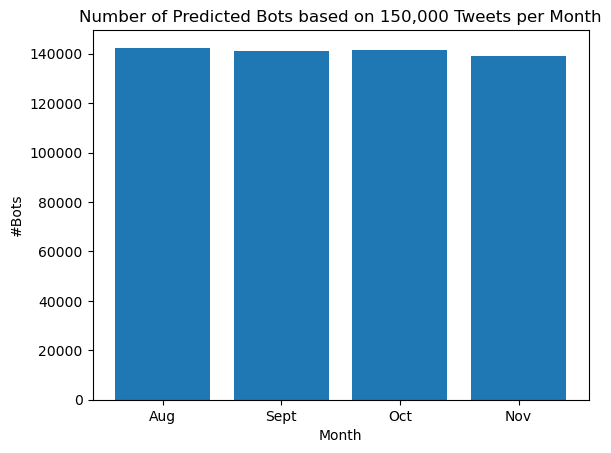

In [14]:
plt.bar(names, predictions)
plt.title('Number of Predicted Bots based on 150,000 Tweets per Month')
plt.xlabel('Month')
plt.ylabel('#Bots')
plt.show()

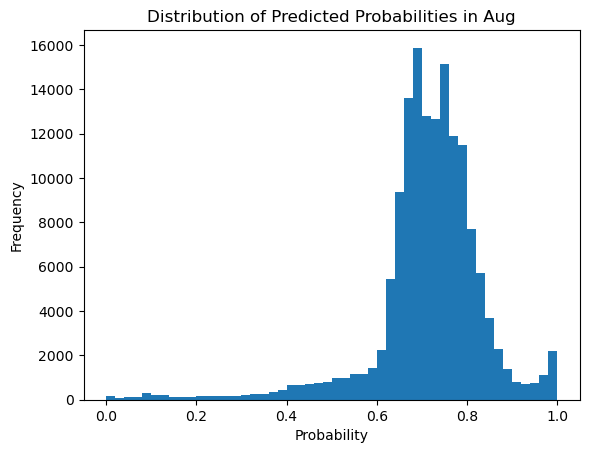

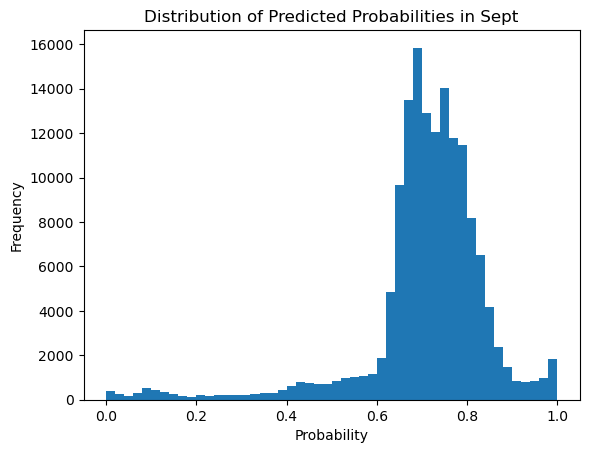

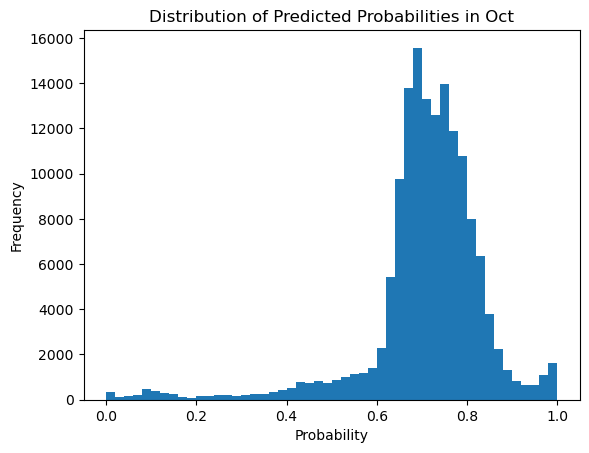

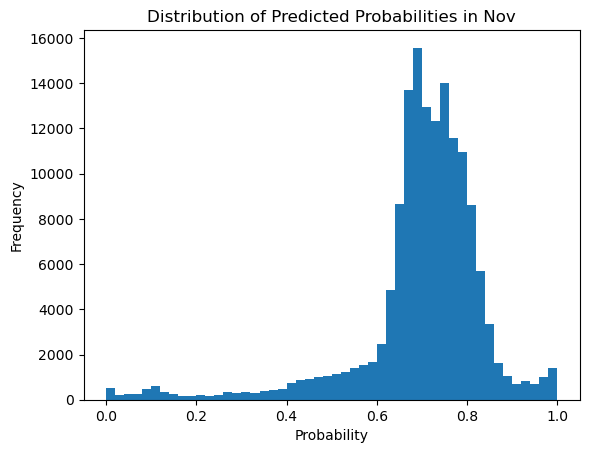

In [15]:
for i in range(len(months)):
    probs = torch.sigmoid(month_soft_predictions[i])
    plt.hist(probs.detach().cpu().numpy(), bins=50, range=(0, 1))
    plt.title(f'Distribution of Predicted Probabilities in {months[i][0]}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()


In [16]:
# pull in the raw tweets to extract the exact tweets
df_aug12 = pd.read_csv("Data/aug_chunk_20.csv.gz",  compression='gzip')
df_aug18 = pd.read_csv("Data/aug_chunk_10.csv.gz",  compression='gzip')
df_aug21 = pd.read_csv("Data/aug_chunk_40.csv.gz",  compression='gzip')

df_sept4 = pd.read_csv("Data/september_chunk_1.csv.gz",  compression='gzip')
df_sept17 = pd.read_csv("Data/september_chunk_30.csv.gz",  compression='gzip')
df_sept20 = pd.read_csv("Data/september_chunk_20.csv.gz",  compression='gzip')

df_oct3 = pd.read_csv("Data/october_chunk_15.csv.gz",  compression='gzip')
df_oct15 = pd.read_csv("Data/october_chunk_10.csv.gz",  compression='gzip')
df_oct31 = pd.read_csv("Data/october_chunk_21.csv.gz",  compression='gzip')

df_nov7 = pd.read_csv("Data/november_chunk_10.csv.gz",  compression='gzip')
df_nov24 = pd.read_csv("Data/november_chunk_20.csv.gz",  compression='gzip')
df_nov29 = pd.read_csv("Data/november_chunk_30.csv.gz",  compression='gzip')

df_aug = pd.concat([df_aug12, df_aug18, df_aug21], axis=0)
df_sept = pd.concat([df_sept4, df_sept17, df_sept20], axis=0)
df_oct = pd.concat([df_oct3, df_oct15, df_oct31], axis=0)
df_nov = pd.concat([df_nov7, df_nov24, df_nov29], axis=0)

In [17]:
# augment the probabilities
df_aug["prob"] = torch.sigmoid(month_soft_predictions[0])
df_sept["prob"] = torch.sigmoid(month_soft_predictions[1])
df_oct["prob"] = torch.sigmoid(month_soft_predictions[2])
df_nov["prob"] = torch.sigmoid(month_soft_predictions[3])

In [18]:
# do a quick print out
print("=== Bot-like Tweets ===")
print(df_aug[df_aug['prob'] >= 0.5]['text'].head(5).to_string(index=False))

print("\n=== Non-Bot Tweets ===")
print(df_aug[df_aug['prob'] < 0.5]['text'].head(5).to_string(index=False))

=== Bot-like Tweets ===
@FoxNews You’re running a crooked GOP candidate...
@TheBadgerCzar @BubblegumOut @jaybleft All quie...
@EFCJamesLynch @BrutalNz Thanks. Puts a bit mor...
@redleg1066 @Bonderant2 @shipwreckedcrew Trump ...
Dan Pena predict Donald Trump 2024 election win...

=== Non-Bot Tweets ===
                                 @RickyDoggin MAGA
                                            Kenal?
@mindful_me2 The man’s scared of Kamala . It’s ...
🗣️ Biden responsabiliza a congresistas de sus p...
@JoeyMannarinoUS Trump returning to X would giv...


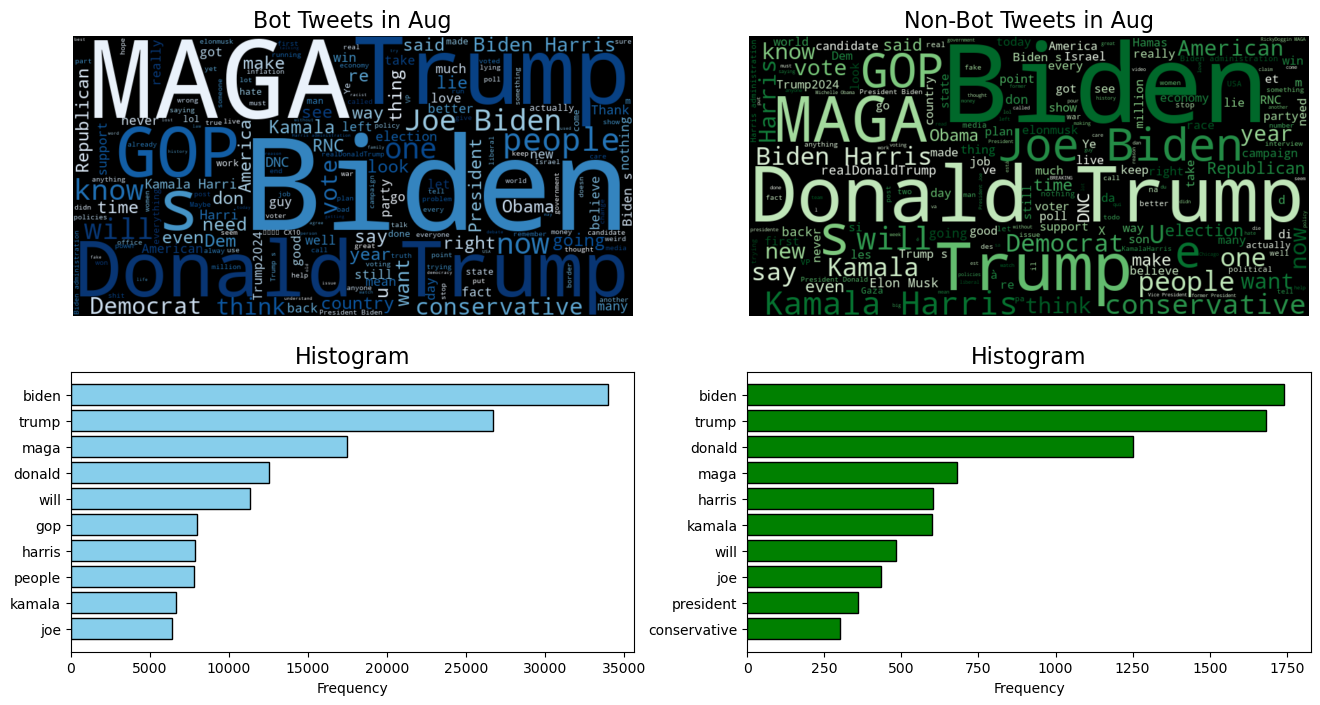

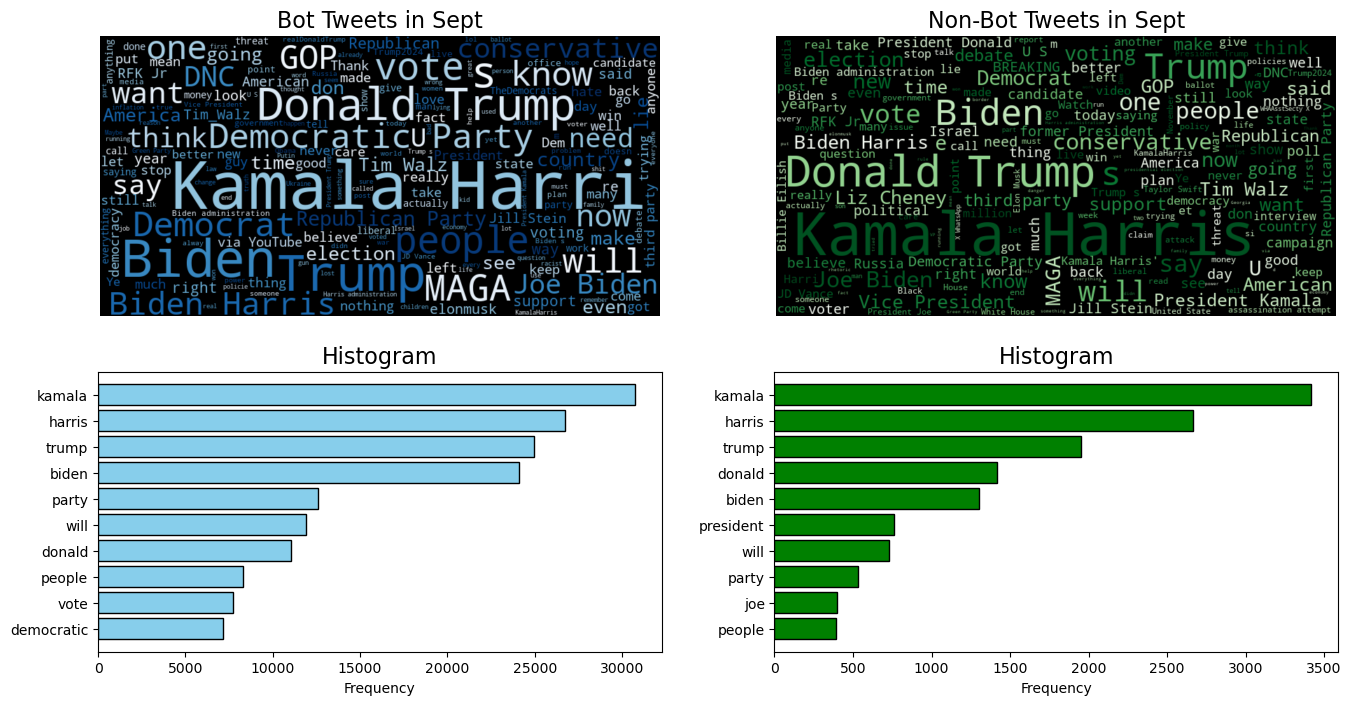

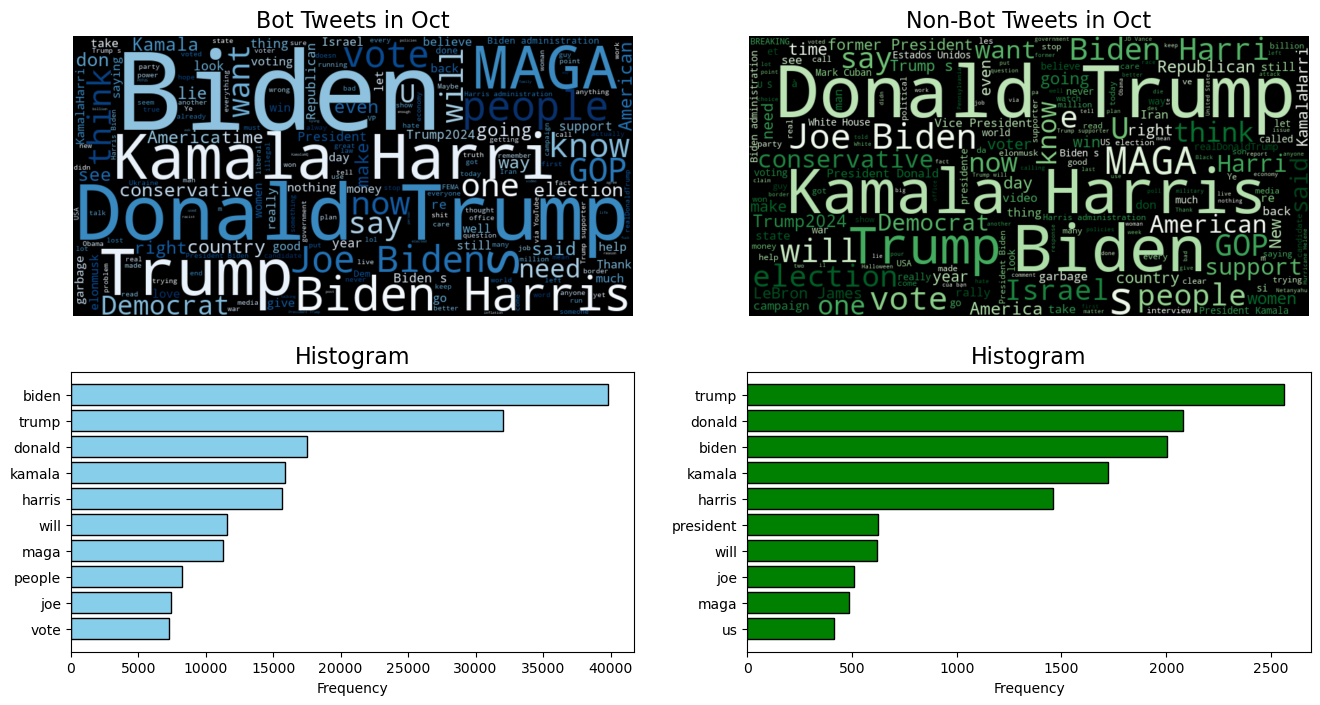

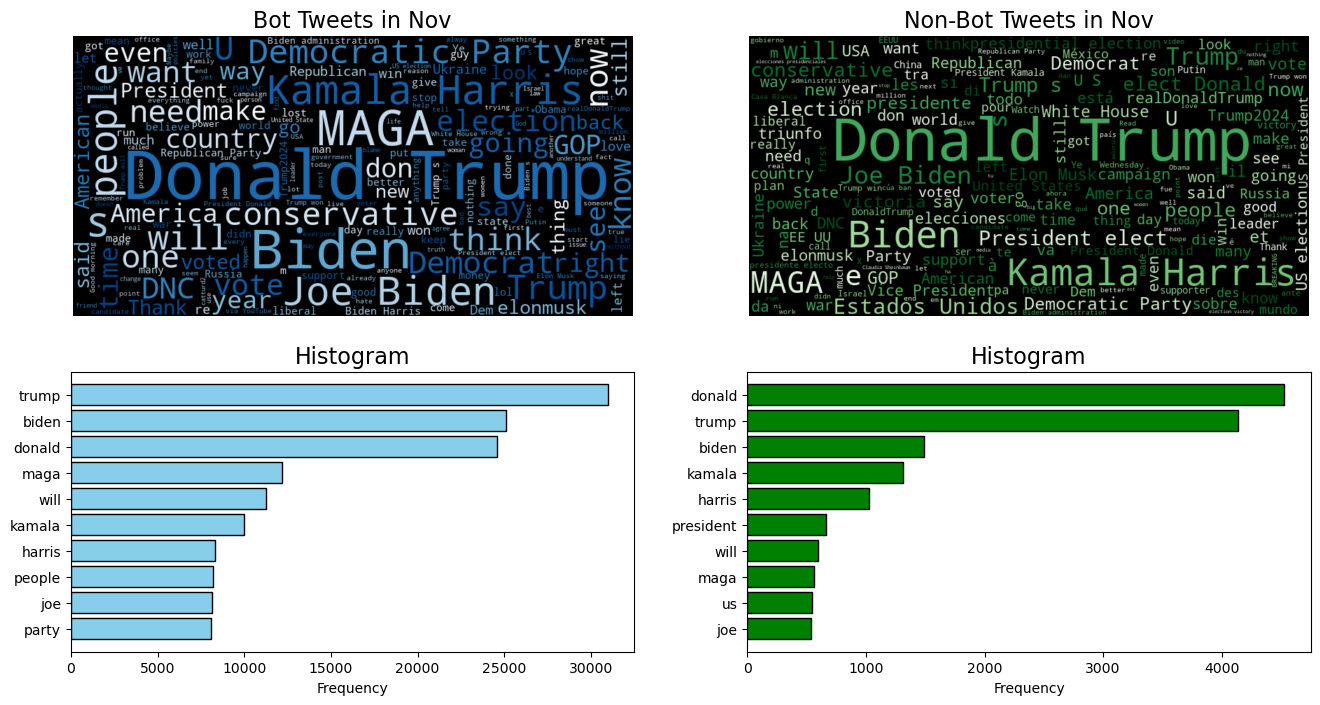

In [19]:
# grab the tweets per month
months_tweets = [("Aug", df_aug), ("Sept", df_sept), ("Oct", df_oct), ("Nov", df_nov)]


for month, df in months_tweets:
    # Combine tweet text into one big string
    bot_text = " ".join(df[df['prob'] >= 0.5]['text'].tolist())
    non_bot_text = " ".join(df[df['prob'] < 0.5]['text'].tolist())

    # make stopwords
    stopwords = set(STOPWORDS)
    stopwords.update([
        "RT", "https", "co", "amp", "t.co", "the", "and", "is", "to", "in", "for", "of", "t", 
        "I", "a", "that", "this", "it", "on", "you", "with", "as", "at", "are", "be", "by", "an", 
        "not", "or", "The", "&amp;", "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
        "por", "un", "para", "con", "no", "una", "su", "al", "lo", "como",
        "más", "pero", "sus", "le", "ya", "o", "este", "sí", "porque", "esta"
    ])

    # Create word clouds
    bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Blues', stopwords= stopwords).generate(bot_text)
    non_bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Greens', stopwords= stopwords).generate(non_bot_text)


    bot_text_split = bot_text.lower().split()
    non_bot_text_split = non_bot_text.lower().split()
    bot_text_split = [word for word in bot_text_split if word not in stopwords]
    non_bot_text_split = [word for word in non_bot_text_split if word not in stopwords]

    bot_word_frequencies = Counter(bot_text_split)
    non_bot_word_frequencies = Counter(non_bot_text_split)

    # Get the most common words for the histogram
    bot_most_common_words = bot_word_frequencies.most_common(10)  
    non_bot_most_common_words = non_bot_word_frequencies.most_common(10) 

    bot_words, bot_frequencies = zip(*bot_most_common_words)
    non_bot_words, non_bot_frequencies = zip(*non_bot_most_common_words)

    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    ax[0][0].imshow(bot_wc, interpolation='bilinear')
    ax[0][0].set_title(f'Bot Tweets in {month}', fontsize=16)
    ax[0][0].axis('off')

    ax[0][1].imshow(non_bot_wc, interpolation='bilinear')
    ax[0][1].set_title(f'Non-Bot Tweets in {month}', fontsize=16)
    ax[0][1].axis('off')

    ax[1][0].barh(bot_words[::-1], bot_frequencies[::-1], color='skyblue', edgecolor='black')
    ax[1][0].set_xlabel('Frequency')
    ax[1][0].set_title("Histogram", fontsize=16)

    ax[1][1].barh(non_bot_words[::-1], non_bot_frequencies[::-1], color='green', edgecolor='black')
    ax[1][1].set_xlabel('Frequency')
    ax[1][1].set_title("Histogram", fontsize=16)


    plt.show()